# TotalSpacecraftBusCurrentSliced_resampled.csv

# Step 1: Load and Preprocess Data

In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data
data_path = '/Users/ankurbaliga/Downloads/TotalSpacecraftBusCurrentSliced_resampled.csv'
data = pd.read_csv(data_path)
data['time'] = pd.to_datetime(data['time (yyyy-MM-dd\'T\'HH:mm:ss.SSS)'])
data = data.set_index('time')
data.drop(columns='time (yyyy-MM-dd\'T\'HH:mm:ss.SSS)', inplace=True)

# Normalize the PWBUSI (A) column
scaler = MinMaxScaler()
data['PWBUSI (A)'] = scaler.fit_transform(data[['PWBUSI (A)']])

# Prepare data for training
X = data['PWBUSI (A)'].values.reshape(-1, 1)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)


# Step 2: Build Convolutional Autoencoder

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, BatchNormalization, Dropout

input_shape = (X_train.shape[1], 1)  # Single feature per timestep

input_layer = Input(shape=input_shape)
x = Conv1D(16, kernel_size=3, padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv1D(8, kernel_size=3, padding='same', activation='relu')(x)
encoded = Conv1D(4, kernel_size=3, padding='same', activation='relu')(x)

x = Conv1DTranspose(8, kernel_size=3, activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv1DTranspose(16, kernel_size=3, activation='relu', padding='same')(x)
decoded = Conv1DTranspose(1, kernel_size=3, activation='sigmoid', padding='same')(x)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 1, 16)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1, 8)           │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 1, 4)           │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_6              │ (None, 1, 8)           │           104 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 8)           │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_7              │ (None, 1, 16)          │           400 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_8              │ (None, 1, 1)           │            49 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,205 (4.71 KB)

 Trainable params: 1,157 (4.52 KB)

 Non-trainable params: 48 (192.00 B)

# Step 3: Train the Autoencoder

In [20]:
# Reshape data for the autoencoder [samples, time steps, features]
X_train_autoencoder = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_autoencoder = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Train the model
history = autoencoder.fit(X_train_autoencoder, X_train_autoencoder, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0814 - val_loss: 0.0079
Epoch 2/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.0045 - val_loss: 0.0016
Epoch 3/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.0030 - val_loss: 8.2976e-04
Epoch 4/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 0.0027 - val_loss: 7.6301e-04
Epoch 5/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 0.0025 - val_loss: 6.7678e-04
Epoch 6/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.0017 - val_loss: 2.8985e-04
Epoch 7/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.0015 - val_loss: 0.0038
Epoch 8/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0014 - val_loss: 3.8815e-04
Epoch 10/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - val_loss: 2.9745e-04
Epoch 11/50
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 9.8941e-04 - val_loss: 5.0147e-04
Epoc

# Step 4: Evaluate the Model


In [21]:
import numpy as np
# Predict on the test data
X_pred = autoencoder.predict(X_test_autoencoder)
mse = np.mean(np.square(X_pred - X_test_autoencoder), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(mse, 95)

# Detect anomalies
anomalies = mse > threshold
print(f'Number of anomalies detected: {np.sum(anomalies)}')


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Number of anomalies detected: 159


# Visualization of Anomalies

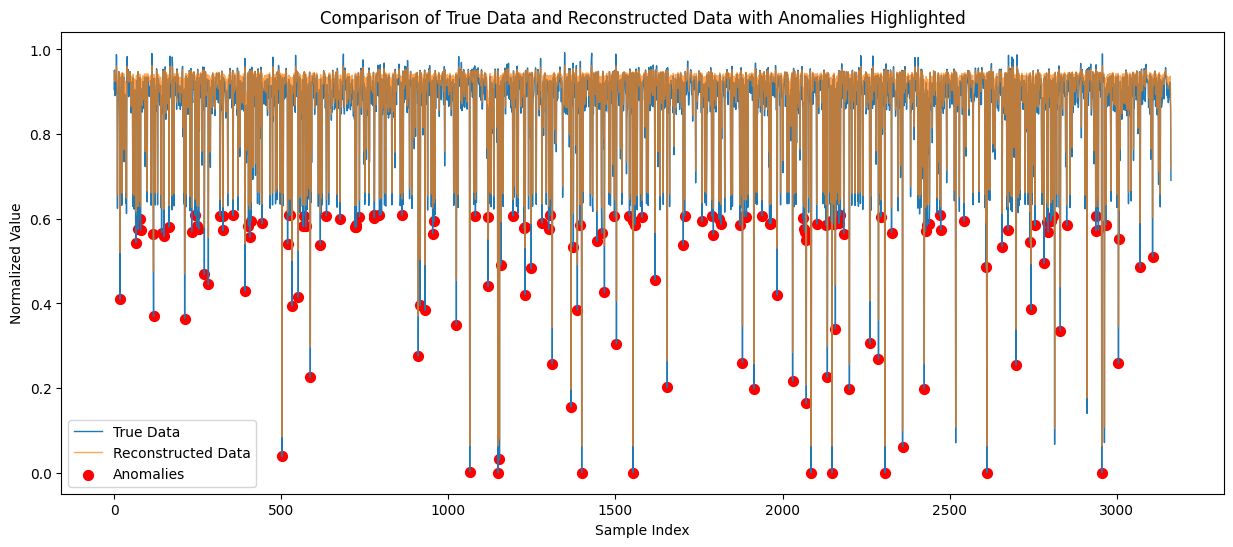

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the test data and predictions if necessary
X_test_flat = X_test_autoencoder.reshape(-1)
X_pred_flat = X_pred.reshape(-1)

# Calculate the MSE for each point
mse = np.square(X_pred_flat - X_test_flat)

# Define a threshold for anomaly detection based on the 95th percentile of the MSE
threshold = np.percentile(mse, 95)

# Identify data points where the reconstruction error exceeds the threshold
anomalies = mse > threshold

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(X_test_flat, label='True Data', linewidth=1)
plt.plot(X_pred_flat, label='Reconstructed Data', linewidth=1, alpha=0.7)

# Highlight anomalies
anomaly_indices = np.where(anomalies)[0]
plt.scatter(anomaly_indices, X_test_flat[anomaly_indices], color='red', s=50, label='Anomalies')

plt.title('Comparison of True Data and Reconstructed Data with Anomalies Highlighted')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()


# TRW1MT csv

# Step 1: Load and Preprocess Data

In [23]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data
data_path = '/Users/ankurbaliga/Downloads/TRcurrentdata.csv'
data = pd.read_csv(data_path, parse_dates=['time (yyyy-MM-dd\'T\'HH:mm:ss.SSS)'])

# Handle missing values (if any)
data = data.dropna()

# Normalize the numerical columns
scaler = MinMaxScaler()
numeric_columns = ['TRW1MT (C)', 'min', 'max', 'count']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Prepare the data for training
X = data[numeric_columns].values
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

data.shape

(4973, 5)

# Step 2: Build Convolutional Autoencoder

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, BatchNormalization, Dropout

# Define the model architecture
input_shape = (X_train.shape[1], 1)  # Single feature per timestep

input_layer = Input(shape=input_shape)
x = Conv1D(16, kernel_size=3, padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv1D(8, kernel_size=3, padding='same', activation='relu')(x)
encoded = Conv1D(4, kernel_size=3, padding='same', activation='relu')(x)

x = Conv1DTranspose(8, kernel_size=3, activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv1DTranspose(16, kernel_size=3, activation='relu', padding='same')(x)
decoded = Conv1DTranspose(1, kernel_size=3, activation='sigmoid', padding='same')(x)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 4, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 4, 16)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 4, 8)           │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 4, 4)           │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_9              │ (None, 4, 8)           │           104 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 8)           │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_10             │ (None, 4, 16)          │           400 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_11             │ (None, 4, 1)           │            49 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,205 (4.71 KB)

 Trainable params: 1,157 (4.52 KB)

 Non-trainable params: 48 (192.00 B)

# Step 3: Train the Autoencoder

In [26]:
 # Reshape data for the autoencoder [samples, time steps, features]
X_train_autoencoder = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_autoencoder = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

 # Train the model
history = autoencoder.fit(X_train_autoencoder, X_train_autoencoder, epochs=50, batch_size=32, validation_split=0.1)



Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3858e-04 - val_loss: 2.3948e-04
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 5.7128e-04 - val_loss: 5.0816e-04
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4491e-04 - val_loss: 2.9383e-04
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 6.0808e-04 - val_loss: 4.7609e-04
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2004e-04 - val_loss: 2.4129e-04
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 5.1491e-04 - val_loss: 8.3172e-04
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3129e-04 - val_loss: 2.6604e-04
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 5.0030e-04 - val_loss: 5.9551e-04
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6783e-04 - val_loss: 4.5558e-04
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4491e-04 - val_loss: 6.7000e-04
Epoch 11/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

# Step 4: Evaluate the Model

In [27]:
from tensorflow.keras.models import load_model
import numpy as np

# Assuming you saved the model with the extension .keras as in your updated training code
# Correct the file path according to how and where you saved your model
model_path = '/Users/ankurbaliga/Downloads/best_autoencoder.keras'

# Load the best model
model = load_model(model_path)

# Predict and calculate MSE
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[:-1])  # Reshape X_pred to match the shape of X_test
mse = np.mean(np.square(X_pred - X_test), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(mse, 95)

# Detect anomalies
anomalies = mse > threshold
print(f'Number of anomalies detected: {np.sum(anomalies)}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Number of anomalies detected: 44


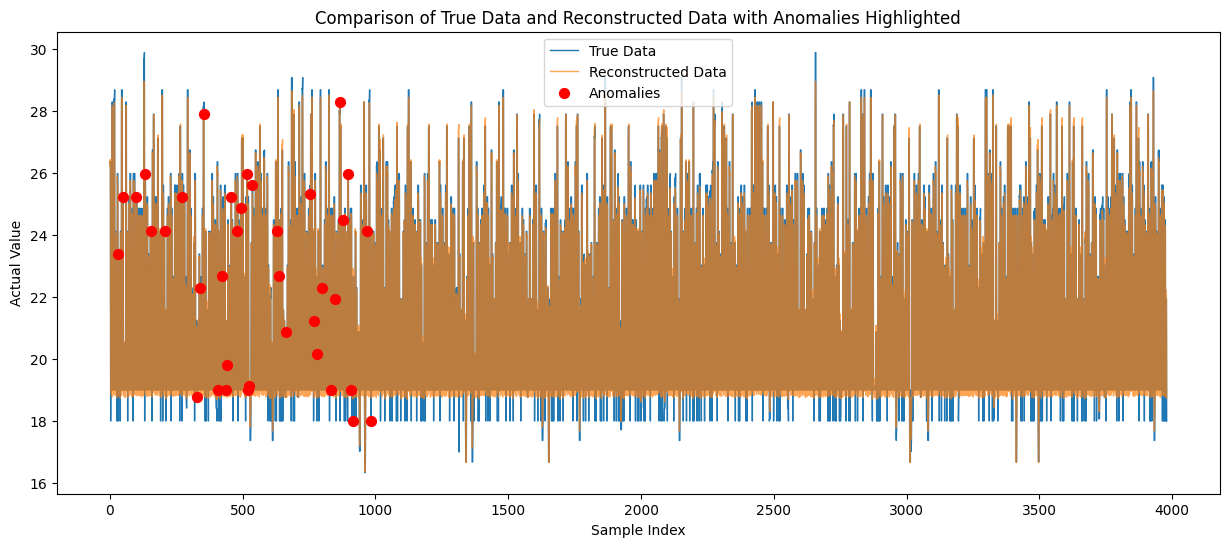

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you've kept the scaler object
# Denormalize the test and predicted data
X_test_denorm = scaler.inverse_transform(X_test.reshape(-1, X_test.shape[-1]))
X_pred_denorm = scaler.inverse_transform(X_pred.reshape(-1, X_pred.shape[-1]))

# Flatten the arrays if they are multidimensional
X_test_flat = X_test_denorm.flatten()
X_pred_flat = X_pred_denorm.flatten()

# Calculate MSE on the denormalized data and detect anomalies
mse = np.mean(np.square(X_pred_denorm - X_test_denorm), axis=1)
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(X_test_flat, label='True Data', linewidth=1)
plt.plot(X_pred_flat, label='Reconstructed Data', linewidth=1, alpha=0.7)

# Highlight anomalies
anomaly_indices = np.where(anomalies)[0]
plt.scatter(anomaly_indices, X_test_flat[anomaly_indices], color='red', s=50, label='Anomalies', zorder=5)

plt.title('Comparison of True Data and Reconstructed Data with Anomalies Highlighted')
plt.xlabel('Sample Index')
plt.ylabel('Actual Value')
plt.legend()
plt.show()


# Wheel1SpeedDirection_resampled.csv

# Step 1: Load and Preprocess Data

In [29]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data
data_path = '/Users/ankurbaliga/Downloads/Wheel1SpeedDirection_resampled.csv'  # Update this path
data = pd.read_csv(data_path)
data['time'] = pd.to_datetime(data['time (yyyy-MM-dd\'T\'HH:mm:ss.SSS)'])
data.set_index('time', inplace=True)

# Normalize the 'ADW1SDIR (RPM)' column
scaler = MinMaxScaler()
data['ADW1SDIR (RPM)'] = scaler.fit_transform(data[['ADW1SDIR (RPM)']])

# Prepare data for training
X = data['ADW1SDIR (RPM)'].values.reshape(-1, 1)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)


# Step 2: Build Convolutional Autoencoder

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, BatchNormalization, Dropout

# Define the model architecture
input_shape = (None, 1)  # Time steps are flexible, one feature per step

input_layer = Input(shape=input_shape)
x = Conv1D(16, kernel_size=3, padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv1D(8, kernel_size=3, padding='same', activation='relu')(x)
encoded = Conv1D(4, kernel_size=3, padding='same', activation='relu')(x)

x = Conv1DTranspose(8, kernel_size=3, activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv1DTranspose(16, kernel_size=3, activation='relu', padding='same')(x)
decoded = Conv1DTranspose(1, kernel_size=3, activation='sigmoid', padding='same')(x)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, None, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, None, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, None, 8)        │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, None, 4)        │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_12             │ (None, None, 8)        │           104 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, None, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, None, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_13             │ (None, None, 16)       │           400 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_14             │ (None, None, 1)        │            49 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,205 (4.71 KB)

 Trainable params: 1,157 (4.52 KB)

 Non-trainable params: 48 (192.00 B)

# Step 3: Train the Autoencoder

In [31]:
# Reshape data for autoencoder [samples, time steps, features]
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

# Train the model
history = autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 866us/step - loss: 0.0576 - val_loss: 6.1065e-05
Epoch 2/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - loss: 2.9566e-04 - val_loss: 4.2292e-05
Epoch 3/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - loss: 2.6873e-04 - val_loss: 7.0911e-05
Epoch 4/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - loss: 2.0975e-04 - val_loss: 3.6508e-05
Epoch 5/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - loss: 1.5642e-04 - val_loss: 1.3128e-06
Epoch 6/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - loss: 1.1858e-04 - val_loss: 1.0090e-06
Epoch 7/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - loss: 5.0654e-05 - val_loss: 1.5594e-04
Epoch 8/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - loss: 5.4495e-05 - val_loss: 9.0518e-05
Epoch 9/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - loss: 1.9293e-05 - val_loss: 5.4548e-04
Epoch 10/50
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - loss: 1.6014e-05 - val_loss: 5.8237e-05
Epoch 11/50
1043/1043 ━

# Step 4: Evaluate the Model and Detect Anomalies

In [32]:
# Prepare test data for prediction
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Predict on test data
X_pred = autoencoder.predict(X_test_reshaped)
mse = np.mean(np.square(X_pred - X_test_reshaped), axis=1)

# Define threshold for anomaly detection
threshold = np.percentile(mse, 95)

# Detect anomalies
anomalies = mse > threshold
print(f'Number of anomalies detected: {np.sum(anomalies)}')


290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
Number of anomalies detected: 464


# Visualization of Anomalies

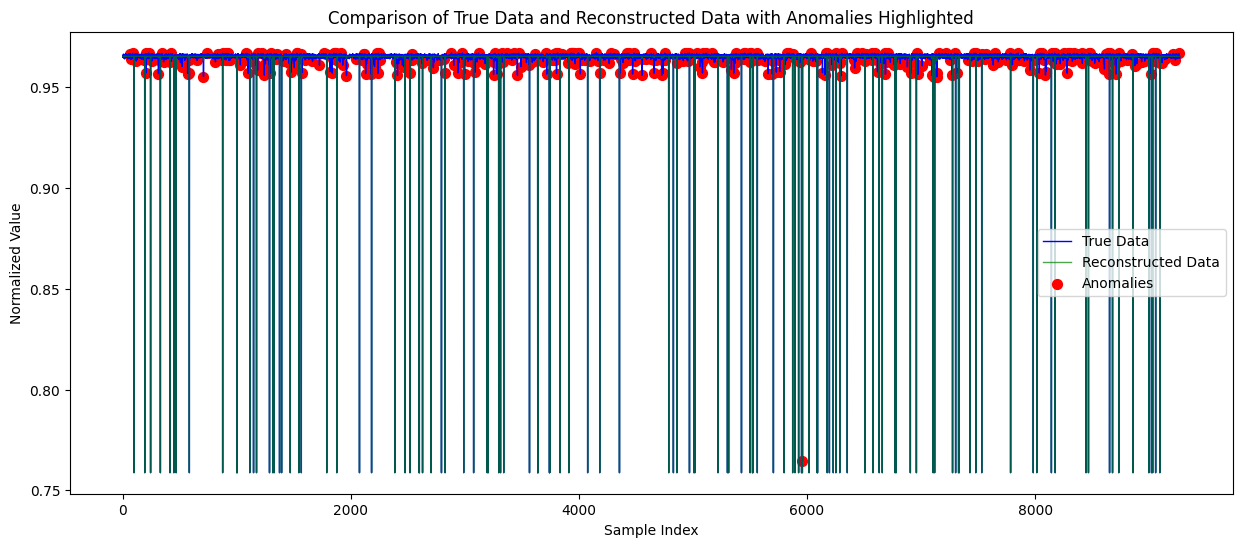

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure predictions and original test data are reshaped for comparison
X_test_flat = X_test_reshaped.reshape(-1)
X_pred_flat = X_pred.reshape(-1)

# Calculate the MSE for each sample
mse = np.square(X_pred_flat - X_test_flat)

# Define a threshold for anomaly detection based on the 95th percentile of the MSE
threshold = np.percentile(mse, 95)

# Identify points where the reconstruction error exceeds the threshold
anomalies = mse > threshold
anomaly_indices = [i for i, x in enumerate(anomalies) if x]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(X_test_flat, label='True Data', color='blue', linewidth=1)
plt.plot(X_pred_flat, label='Reconstructed Data', color='green', alpha=0.7, linewidth=1)

# Highlight anomalies with red dots
plt.scatter(anomaly_indices, X_test_flat[anomaly_indices], color='red', s=50, label='Anomalies')

plt.title('Comparison of True Data and Reconstructed Data with Anomalies Highlighted')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()
